In [ ]:
#!pip install opencv-python
!pip install opencv-contrib-python --user

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
img_path = "/content/drive/MyDrive/TP2-VisionParOrdinateur/coil-100"

list_file = [f for f in os.listdir(img_path) if os.path.isfile(os.path.join(img_path, f))]

list_image = []
list_label = []

for file in list_file :
    if file.split(".")[1] == 'png':
        img = cv2.imread(img_path+"/"+file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        list_image.append(img)
        list_label.append(file.split('__')[0])

list_image = np.array(list_image)
print(list_image.shape)

list_label = np.array(list_label)
print(list_label.shape)

(7200, 128, 128, 3)
(7200,)


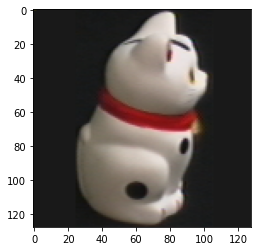

In [ ]:
plt.imshow(list_image[400])

In [ ]:
# Division des images en train et test
X_train, X_test, y_train, y_test = train_test_split(list_image, list_label, test_size=0.2, random_state=100)
print("Nombre d'image d'entrainement : {}".format(X_train.shape[0]))
print("Nombre d'image de test : {}".format(X_test.shape[0]))

Nombre d'image d'entrainement : 5760
Nombre d'image de test : 1440


In [ ]:
sift = cv2.xfeatures2d.SIFT_create()

In [ ]:
# Créer les descripteurs et les points clés de toutes les images d'entrainement
X_key = []
X_descriptor = []

for img in X_train:
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kp, des = sift.detectAndCompute(img_gray, None)
    X_key.append(kp)
    X_descriptor.append(des)
    
X_key = np.array(X_key)
X_descriptor = np.array(X_descriptor)
print(X_key.shape)
print(X_descriptor.shape)

(5760,)
(5760,)


In [ ]:
print(X_descriptor[2].shape)

(39, 128)


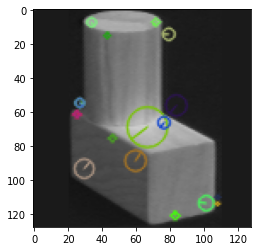

In [ ]:
i = 10
img = cv2.drawKeypoints(cv2.cvtColor(X_train[i], cv2.COLOR_RGB2GRAY), X_key[i], X_train[i], flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)

In [ ]:
# Calcul scrore descripteur

def score(descripteur_image_test):
    #bf = cv2.BFMatcher()
    scores = [0] * len(X_train)
    
    for ind, img in enumerate(X_descriptor):
        #Matching
        #matches = bf.knnMatch(img, descripteur_image_test, k=2)
        
        # FLANN parameters
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks=50)   # or pass empty dictionary
        flann = cv2.FlannBasedMatcher(index_params,search_params)
        try:
            matches = flann.knnMatch(img,descripteur_image_test,k=2)
            
            # Apply ratio test
            good = []
            for m,n in matches:
                if m.distance < 0.4*n.distance:
                    good.append([m])

            #Enr&gistrement du score
            scores[ind] = len(good) / X_descriptor.shape[0]
        except:
            scores[ind] = 0
        
        
    return scores

In [ ]:
# Recherche des k meuilleurs scores

def find_k_best(scores, k=3):
    best_index = [0] * k
    
    for ind in range(k):
        maximum = max(scores)
        i = scores.index(maximum)
        best_index[ind] = y_train[i]
        scores[i] = -1
        
    return np.array(best_index)

In [ ]:
# Tracer le match

def draw_machest(ind_train, des2, kp2, img2):
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(X_descriptor[ind_train], des2, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.9*n.distance:
            good.append([m])

    # cv.drawMatchesKnn expects list of lists as matches.
    img3 = cv2.drawMatchesKnn(X_train[ind_train], X_key[ind_train], img2, kp2, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return img3

In [ ]:
img_test = X_test[254]
predc, img_match = predict(img_test)
print("La prédiction est : {}".format(predc))
img_match.squeeze().permute(1,2,0)
plt.imshow(img_match)

La prédiction est : obj31


AttributeError: 'list' object has no attribute 'squeeze'

In [ ]:
# Prédiction
def predict(img_test):
    img_test_gray = cv2.cvtColor(img_test, cv2.COLOR_RGB2GRAY)
    kp_test, des_test = sift.detectAndCompute(img_test_gray, None)
    liste_scores = score(des_test)
    rep = find_k_best(liste_scores, 5)
    rep_, nbre = np.unique(rep, return_counts=True)
    ind = np.where(nbre == max(nbre))[0]
    best_index = np.where(y_train == rep_[ind][0])
    img_draw = []
    #img_draw = draw_machest(best_index[0][0], des_test, kp_test, img_test)

    return rep_[ind][0], img_draw

In [ ]:
# evaluation

y_predit = [0] * y_test.shape[0]

for ind, img in enumerate(X_test):
    predc, img_match = predict(X_test[ind])
    y_predit[ind] = predc
    

print("Le score est : {}".format(sum(y_predit == y_test) / X_train.shape[0]))

Le score est : 0.23819444444444443


In [ ]:
sum(y_predit == y_test) / X_train.shape[0]

0.23819444444444443

In [ ]:
y_predit

['obj73',
 'obj76',
 'obj14',
 'obj41',
 'obj3',
 'obj60',
 'obj68',
 'obj12',
 'obj73',
 'obj46',
 'obj89',
 'obj9',
 'obj39',
 'obj1',
 'obj43',
 'obj30',
 'obj34',
 'obj100',
 'obj34',
 'obj68',
 'obj7',
 'obj91',
 'obj66',
 'obj39',
 'obj91',
 'obj17',
 'obj69',
 'obj80',
 'obj44',
 'obj34',
 'obj52',
 'obj54',
 'obj68',
 'obj3',
 'obj6',
 'obj68',
 'obj83',
 'obj22',
 'obj40',
 'obj55',
 'obj87',
 'obj68',
 'obj27',
 'obj73',
 'obj92',
 'obj13',
 'obj52',
 'obj25',
 'obj26',
 'obj16',
 'obj41',
 'obj89',
 'obj65',
 'obj25',
 'obj91',
 'obj87',
 'obj86',
 'obj37',
 'obj68',
 'obj58',
 'obj90',
 'obj9',
 'obj68',
 'obj68',
 'obj96',
 'obj38',
 'obj91',
 'obj68',
 'obj49',
 'obj5',
 'obj41',
 'obj16',
 'obj78',
 'obj51',
 'obj40',
 'obj50',
 'obj98',
 'obj43',
 'obj78',
 'obj43',
 'obj8',
 'obj68',
 'obj85',
 'obj3',
 'obj49',
 'obj35',
 'obj55',
 'obj37',
 'obj34',
 'obj42',
 'obj3',
 'obj37',
 'obj75',
 'obj53',
 'obj100',
 'obj85',
 'obj15',
 'obj28',
 'obj57',
 'obj49',
 'obj59',

In [ ]:
y_test

array(['obj73', 'obj76', 'obj14', ..., 'obj61', 'obj49', 'obj73'],
      dtype='<U6')

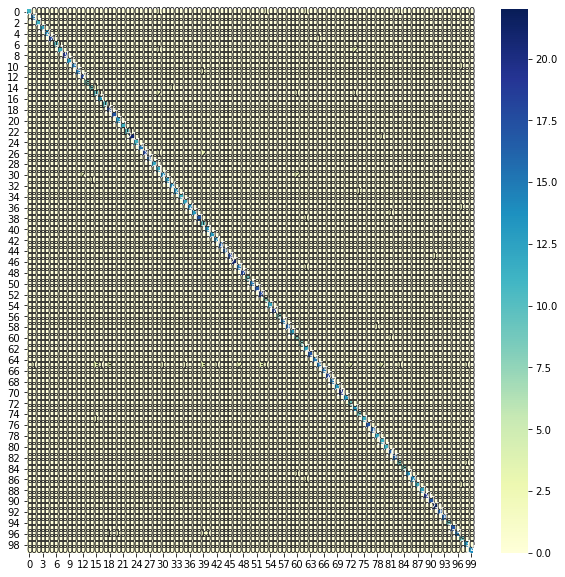

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

conf = confusion_matrix(y_predit, y_test)

plt.figure(figsize = (10, 10))
sn.heatmap(conf, annot=True, cmap="YlGnBu")